![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Compute TWS rates for the relevant basins

# Read data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr 
import shxarray
import numpy as np
import matplotlib.pyplot as plt

from common.config import read_config

In [3]:
conf=read_config()
datadir=conf["dataroot"]

In [4]:
tws_sh=os.path.join(datadir,conf["nctws"])
dtws=xr.open_dataset(tws_sh)
dtws=dtws.sh.build_nmindex()
display(dtws)
ncbasins=os.path.join(datadir,conf["ncbasin"])
dsbasins_sh=xr.open_dataset(ncbasins).sh.truncate(nmax=96)
dsbasins_sh=dsbasins_sh.sh.build_nmindex()

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 230, nm: 9408)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-04-15T12:...
  * nm       (nm) object 75kB MultiIndex
  * n        (nm) int64 75kB 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 75kB 0 1 -1 0 1 -1 2 -2 ... 93 -93 94 -94 95 -95 96 -96
Data variables:
    tws      (time, nm) float64 17MB ...

In [5]:
shxengine='shtns'
dsbasinav=dtws.tws.sh.basinav(dsbasins_sh.basins, filtername="Gauss300", leakage_corr="scale", engine=shxengine).compute()

Alternatively, read the ncbasav dataset, which includes TWS anomalies processed with a DDK5 filter and two different methods for reducing leakage errors

In [6]:
nctws=os.path.join(datadir,conf["ncbasav"])
dsbasinav=xr.open_dataset(nctws)
display(dsbasinav)

<xarray.Dataset> Size: 478kB
Dimensions:          (name: 124, time: 230)
Coordinates:
  * name             (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time             (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-0...
Data variables:
    tws_ddk5_vw2016  (name, time) float64 228kB ...
    tws_ddk5_scaled  (name, time) float64 228kB ...

# Time derivatives of TWS anomalies

# Bspline smoothing

We create an approximation of the TWSA time series from GRCAE/GRACE-FO using the Bspline smoothing method. The advantage of this method is that it does not require passing from all data points of GRACE and GRACE_FO observations, which are noisy.

The approximated version is indicated for GRACE-FO time series.

In [7]:
from scipy.interpolate import splrep, BSpline

In [8]:
def twsrate(dsbasinav,timestps,deg,smoothinglvl):
    
    tck=splrep(timestps,dsbasinav,k=deg,s=smoothinglvl)
    bs=BSpline(*tck)
    bs_dr=bs.derivative()
    dydt=bs_dr(timestps)
    return dydt

In [9]:
timestps=(dsbasinav.time-dsbasinav.time[0])/np.timedelta64(1,"s")
deg=3
smoothinglvl=len(timestps)-np.sqrt(2*len(timestps))

bsdsdt=xr.apply_ufunc(twsrate,dsbasinav[["tws_ddk5_vw2016","tws_ddk5_scaled"]],dsbasinav.time,deg,smoothinglvl,input_core_dims=[["time"],["time"],[],[]],output_core_dims=[["time"]],vectorize=True)

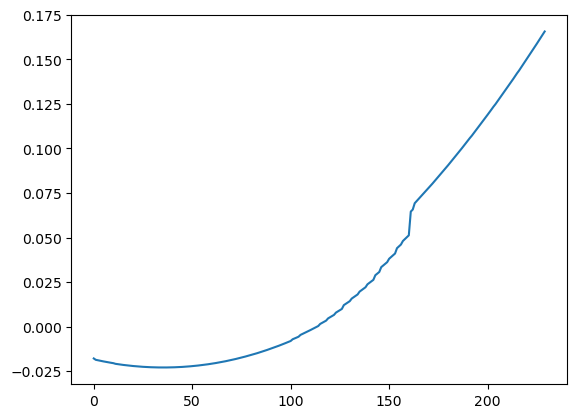

In [10]:
tck=splrep(timestps,dsbasinav.tws_ddk5_vw2016.sel(name="NILE"),k=deg,s=smoothinglvl)
bs=BSpline(*tck)
bss=bs(timestps)
plt.plot(bss)

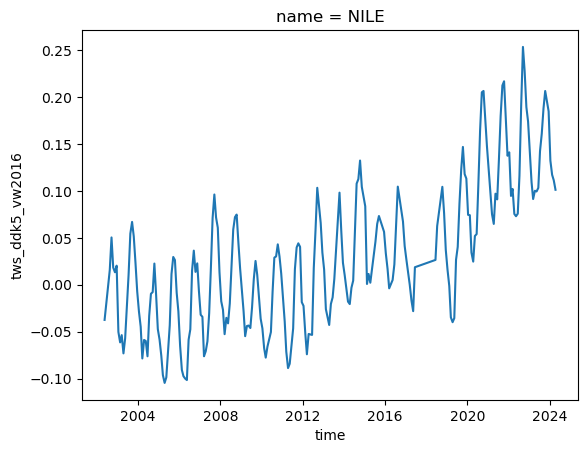

In [11]:
dsbasinav.tws_ddk5_vw2016.sel(name="NILE").plot()

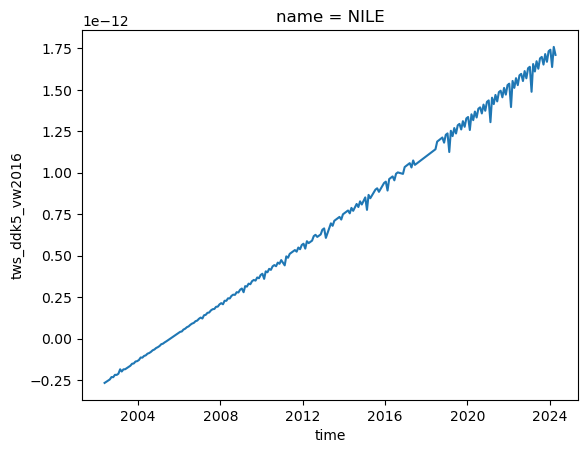

In [12]:
N=dsbasinav.time.dt.days_in_month
bsdsdt_month = bsdsdt*N*3600*24
bsdsdt_month.tws_ddk5_vw2016.sel(name="NILE").plot()

# Comparing with other methods

In [13]:
def tws_time_derivatives(dsbasinav):

    # if mean:
    #     dsbasinav=dsbasinav-dsbasinav.mean(dim="time")
    
    dt=dsbasinav.time.diff("time",label='upper')/np.timedelta64(1,"s")
    deltatws=dsbasinav.diff("time",label='upper')
    dsdt_backward=deltatws/dt
    dsdt_backward = dsdt_backward.reindex(time=dsbasinav.time)

    dsdt_derivatives=dsbasinav.differentiate(coord="time",edge_order=1,datetime_unit="s")

    dt_center=(dsbasinav.time.shift(time=-1)-dsbasinav.time.shift(time=1))/np.timedelta64(1,"s")
    dsdt_central=(dsbasinav.shift(time=-1)-dsbasinav.shift(time=1))/dt_center

    dsdtbasinav=dsbasinav

    dsdtbasinav["cntrdiff_vw2016"]=dsdt_central.tws_ddk5_vw2016
    dsdtbasinav["cntrdiff_scaled"]=dsdt_central.tws_ddk5_scaled

    dsdtbasinav["bckdiff_vw2016"]=dsdt_backward.tws_ddk5_vw2016
    dsdtbasinav["bckdiff_scaled"]=dsdt_backward.tws_ddk5_scaled

    dsdtbasinav["difft_vw2016"]=dsdt_derivatives.tws_ddk5_vw2016
    dsdtbasinav["difft_scaled"]=dsdt_derivatives.tws_ddk5_scaled

    return dsdtbasinav
    

In [14]:
dsdtbasinav=tws_time_derivatives(dsbasinav)

In [15]:
dsdtbasinav["bs_vw2016"]=bsdsdt.tws_ddk5_vw2016
dsdtbasinav["bs_scaled"]=bsdsdt.tws_ddk5_scaled

dsdtbasinav=dsdtbasinav.reset_coords(names=["n","m","nm"],drop=True)

In [16]:
dsdtbasinav

<xarray.Dataset> Size: 2MB
Dimensions:          (name: 124, time: 230)
Coordinates:
  * name             (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time             (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-0...
Data variables:
    tws_ddk5_vw2016  (name, time) float64 228kB -0.08029 0.02309 ... 0.1287
    tws_ddk5_scaled  (name, time) float64 228kB -0.3293 -0.00561 ... 0.1427
    cntrdiff_vw2016  (name, time) float64 228kB nan 1.106e-08 ... 2.605e-09 nan
    cntrdiff_scaled  (name, time) float64 228kB nan 3.834e-08 ... 2.939e-09 nan
    bckdiff_vw2016   (name, time) float64 228kB nan 1.301e-08 ... -7.084e-09
    bckdiff_scaled   (name, time) float64 228kB nan 4.072e-08 ... -7.776e-09
    difft_vw2016     (name, time) float64 228kB 1.301e-08 ... -7.084e-09
    difft_scaled     (name, time) float64 228kB 4.072e-08 ... -7.776e-09
    bs_vw2016        (name, time) float64 228kB -8.242e-20 ... 2.737e-19
    bs_scaled        (name, time) float64 228kB -8.1e-19 -7.677e-19 ... 3e-19

In [17]:
# save to netcdf for re-use

dsdtout=os.path.join(datadir,conf['dsdt'])
dsdtbasinav.to_netcdf(dsdtout)

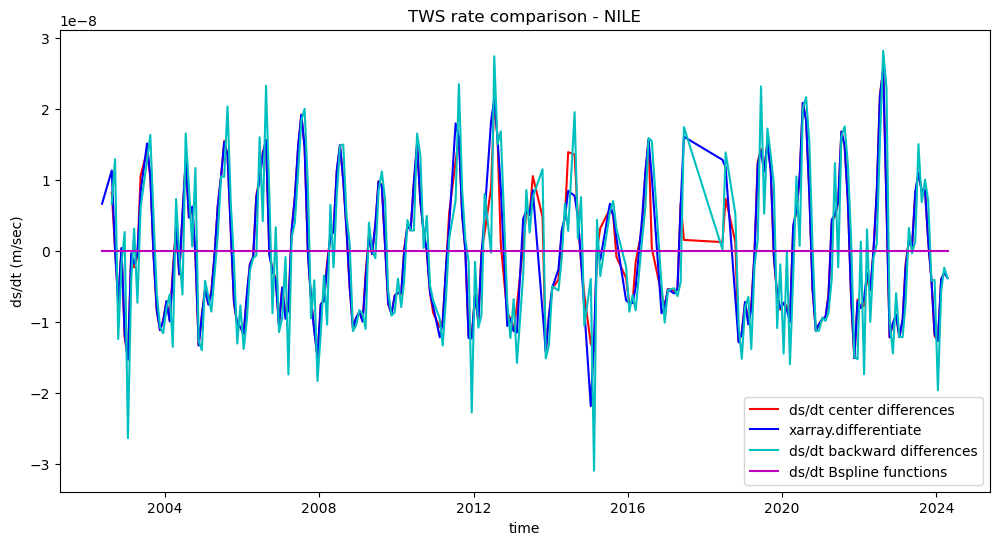

In [21]:
plt.figure(figsize=(12,6))

basinname="NILE"

plt.plot(dsdtbasinav.time,dsdtbasinav.cntrdiff_vw2016.sel(name=basinname),label="ds/dt center differences",color="r")
plt.plot(dsdtbasinav.time,dsdtbasinav.difft_vw2016.sel(name=basinname),label="xarray.differentiate",color="b")
plt.plot(dsdtbasinav.time,dsdtbasinav.bckdiff_vw2016.sel(name=basinname),label="ds/dt backward differences",color="c")
plt.plot(dsdtbasinav.time,dsdtbasinav.bs_vw2016.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate comparison - {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()


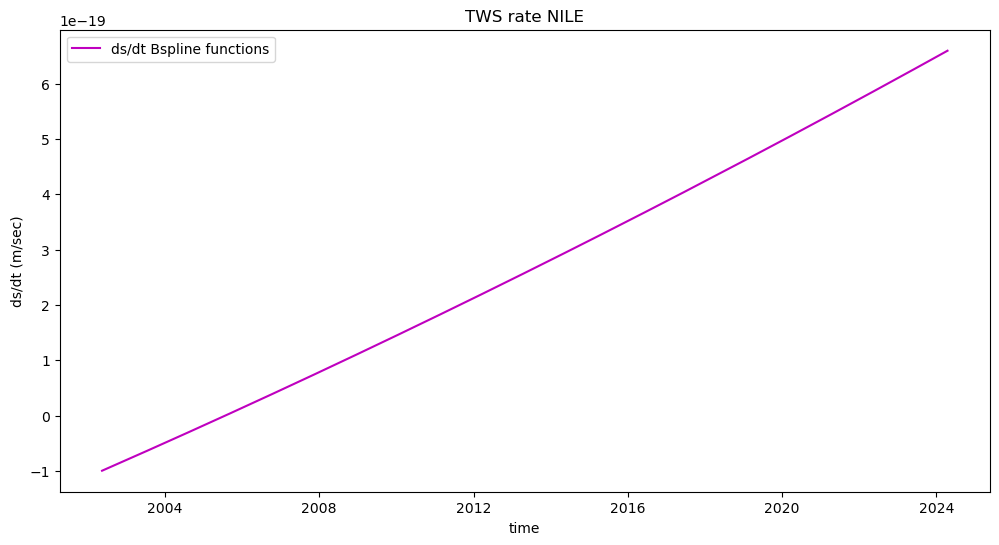

In [22]:
plt.figure(figsize=(12,6))

basinname="NILE"

plt.plot(dsdtbasinav.time,dsdtbasinav.bs_vw2016.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()